In [1]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from textwrap import wrap
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from glob import glob
import PIL
import re


# for data preparation and others
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# models tried
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
#Data Preprocessing

df = pd.read_csv("df_new.csv", delimiter=",", header = None)
X = df.iloc[1:]
X = np.asarray(X.values)
X = np.delete(X, 0, 1)
X = np.transpose(X)

y = df.iloc[0]
y = y[1:]
y = np.asarray(y)
y = np.transpose(y)

features_names = df.iloc[1:]
features_names = features_names.iloc[:,0]
features_names = np.asarray(features_names)
target_names = df.iloc[0]
target_names = target_names[1:]
target_names = np.asarray(target_names)
target_names = np.transpose(target_names)


indx = []
for i in range(len(features_names)):
  indx.append(i)
print(len(features_names))

60488


In [3]:
#splitting the data into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)


In [4]:
#normalizing or scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [5]:
#filter technique (Mutual Information [MI])
startTime = time.time()
mi = mutual_info_classif(X_train, y_train, discrete_features='auto', n_neighbors=3, copy=True, random_state=42)
endTime = time.time()
print('Time: ' + str(endTime - startTime))


Time: 106.29351830482483


In [6]:
#oraganizing MI data
gains = np.asarray(mi)
indexes = np.where(gains != 0)[0]
print(len(indexes))


45292


In [7]:
#Confusion matrix (19 features of MI) *******
#changing the class to discrete numbers for ROC AUC calculation
ss = 0
pp = 0
y_binary = y.copy()

for i in range(0, y_binary.size):
    if (y_binary[i] == "Primary Tumor"):
        y_binary[i] = int(0)
        pp = pp + 1
    if (y_binary[i] == "Solid Tissue Normal"):
        y_binary[i] = int(1)
        ss = ss + 1
y_binary=y_binary.astype('int')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-19:]
startTime = time.time()
x_train = X_train[:, it]
x_test = X_test[:, it]
Y_train = y_train[:]
Y_test = y_test[:]
x_train = x_train.astype('float32')
X_test = x_test.astype('float32')

clf = LinearSVC(random_state=42)
clf.fit(x_train, Y_train)
scores = clf.score(x_test, Y_test)
endTime = time.time()
print('Score: ' + str(scores))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(x_test)


print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))




Score: 0.9863636363636363
Time: 0.003312826156616211
[[198   0]
 [  3  19]]
                     precision    recall  f1-score   support

      Primary Tumor       0.99      1.00      0.99       198
Solid Tissue Normal       1.00      0.86      0.93        22

           accuracy                           0.99       220
          macro avg       0.99      0.93      0.96       220
       weighted avg       0.99      0.99      0.99       220

0.9863636363636363
(0.9865671641791044, 0.9863636363636363, 0.9859160095360352, None)


In [8]:
res = []
for l in ['Primary Tumor', 'Solid Tissue Normal']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

In [9]:
pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*198)+(res[1][1]*22))/220
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*198)+(res[1][2]*22))/220
print("Sensitivity: ", sensitivity)

Specificity:  0.8772727272727273
Sensitivity:  0.9863636363636363


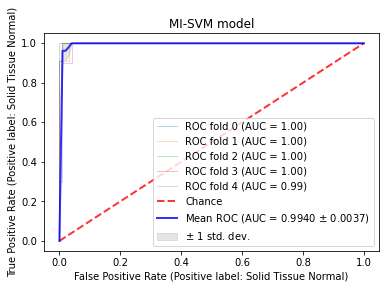

In [10]:
#############################################################################
# Classification and ROC analysis for MI-SVM model




# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
classifier = LinearSVC(random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    X_train = sc.fit_transform(X[train])
    X_train = X_train[:, it]
    X_test = sc.transform(X[test])
    X_test = X_test[:,it]
    
    classifier.fit(X_train, y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="MI-SVM model",
)
ax.legend(loc="lower right")
plt.show()

No Skill: ROC AUC=0.500
Model: ROC AUC=0.992


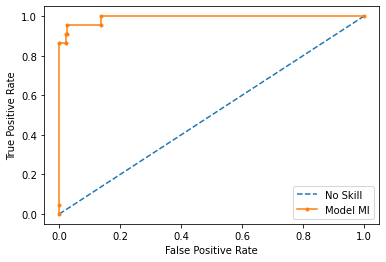

In [11]:
#ROC AUC calculations for the 19 features of MI Model

#changing the class to discrete numbers for ROC AUC calculation
ss = 0
pp = 0
y_test_binary = y_test.copy()
y_train_binary = y_train.copy()

for i in range(0, y_test_binary.size):
    if (y_test_binary[i] == "Primary Tumor"):
        y_test_binary[i] = int(0)
        pp = pp + 1
    if (y_test_binary[i] == "Solid Tissue Normal"):
        y_test_binary[i] = int(1)
        ss = ss + 1
y_test_binary=y_test_binary.astype('int')

for i in range(0, y_train_binary.size):
    if (y_train_binary[i] == "Primary Tumor"):
        y_train_binary[i] = int(0)
        pp = pp + 1
    if (y_train_binary[i] == "Solid Tissue Normal"):
        y_train_binary[i] = int(1)
        ss = ss + 1
y_train_binary=y_train_binary.astype('int')


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_binary))]


Y_train_binary = y_train_binary[:]
Y_test_binary = y_test_binary[:]

# predict probabilities
model = LinearSVC(random_state=42)
model.fit(x_train, Y_train_binary)
lr_probs = model.decision_function(x_test)

# calculate scores
ns_auc = roc_auc_score(Y_test_binary, ns_probs)
lr_auc = roc_auc_score(Y_test_binary, lr_probs)
# summarize scores: prints the ROC AUC for the model and the no skill classifier that only predicts 0 for all samples
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test_binary, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test_binary, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Model MI')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


In [12]:
#to get the common features between top 19 MI features and the features of the 345 trees in the Random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
ST = time.time()
regressor = RandomForestClassifier(n_estimators=345, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
sorted_features = sorted (zip(map(lambda x: round(x, 4), regressor.feature_importances_), indx),reverse=True)
important_f = []
  

for s in sorted_features:
  if s[0] != 0:
    important_f.append(s[1])
important_f = np.transpose(important_f)
important_f = np.asarray(important_f)

#checking the similarities in the first 19 features in MI with features used in RF (n_estimators = 345)
it = sorted(range(len(gains)), key = lambda sub: gains[sub])[-19:]
similarity = []
count = 0
for f in important_f:
  for t in it:
    if (f == t):
      count = count + 1
      similarity.append(f)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))
print("the number of important features used: ", len(important_f))
print ("number of similar features: ", len(similarity))  

ET = time.time()
print("time: ", ET - ST)
print("\n")


0.9863636363636363
[[198   0]
 [  3  19]]
                     precision    recall  f1-score   support

      Primary Tumor       0.99      1.00      0.99       198
Solid Tissue Normal       1.00      0.86      0.93        22

           accuracy                           0.99       220
          macro avg       0.99      0.93      0.96       220
       weighted avg       0.99      0.99      0.99       220

(0.9865671641791044, 0.9863636363636363, 0.9859160095360352, None)
the number of important features used:  1261
number of similar features:  18
time:  2.205292224884033




In [13]:
res = []
for l in ['Primary Tumor', 'Solid Tissue Normal']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*198)+(res[1][1]*22))/220
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*198)+(res[1][2]*22))/220
print("Sensitivity: ", sensitivity)

Specificity:  0.8772727272727273
Sensitivity:  0.9863636363636363


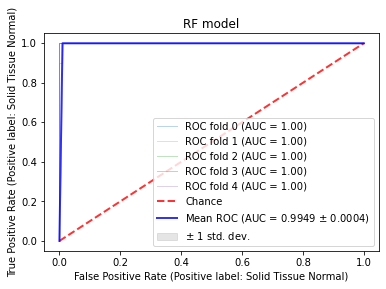

In [14]:
#############################################################################
# Classification and ROC analysis



# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
classifier = RandomForestClassifier(n_estimators=345, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    X[train] = sc.fit_transform(X[train])
    X[test] = sc.transform(X[test])
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="RF model",
)
ax.legend(loc="lower right")
plt.show()

No Skill: ROC AUC=0.500
Model: ROC AUC=1.000


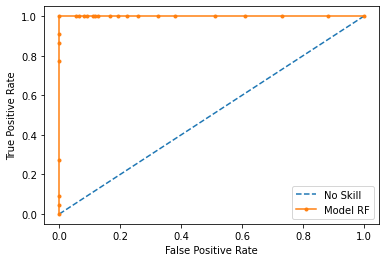

In [15]:
#ROC AUC calculations for the 1264 features of 345 trees in Random Forest Model

#changing the class to discrete numbers for ROC AUC calculation
ss = 0
pp = 0
y_test_binary = y_test.copy()
y_train_binary = y_train.copy()

for i in range(0, y_test_binary.size):
    if (y_test_binary[i] == "Primary Tumor"):
        y_test_binary[i] = int(0)
        pp = pp + 1
    if (y_test_binary[i] == "Solid Tissue Normal"):
        y_test_binary[i] = int(1)
        ss = ss + 1
y_test_binary=y_test_binary.astype('int')

for i in range(0, y_train_binary.size):
    if (y_train_binary[i] == "Primary Tumor"):
        y_train_binary[i] = int(0)
        pp = pp + 1
    if (y_train_binary[i] == "Solid Tissue Normal"):
        y_train_binary[i] = int(1)
        ss = ss + 1
y_train_binary=y_train_binary.astype('int')


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_binary))]


Y_train_binary = y_train_binary[:]
Y_test_binary = y_test_binary[:]

# predict probabilities
regressor = RandomForestClassifier(n_estimators=345, random_state=42)
regressor.fit(X_train, y_train_binary)
lr_probs = regressor.predict_proba(X_test)
lr_probs = lr_probs[:, 1]


# calculate scores
ns_auc = roc_auc_score(Y_test_binary, ns_probs)
lr_auc = roc_auc_score(Y_test_binary, lr_probs)
# summarize scores: prints the ROC AUC for the model and the no skill classifier that only predicts 0 for all samples
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test_binary, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test_binary, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Model RF')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


In [16]:
#The wrapper method (recursive feature elimination RFE) 76 features only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

startTime = time.time()
estimator = LinearSVC(random_state=42)
selector = RFE(estimator, n_features_to_select= 76, step=0.5)
selector = selector.fit(X_train, y_train)
endTime = time.time()
print('Time: ' + str(endTime - startTime))
# testing the model
y_pred = selector.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(selector.score(X_test, y_test))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))

print(np.count_nonzero(selector.support_ == 1))


(329, 60488)
(329,)
(220, 60488)
(220,)
Time: 3.5115091800689697
0.9772727272727273
0.9772727272727273
[[195   3]
 [  2  20]]
                     precision    recall  f1-score   support

      Primary Tumor       0.99      0.98      0.99       198
Solid Tissue Normal       0.87      0.91      0.89        22

           accuracy                           0.98       220
          macro avg       0.93      0.95      0.94       220
       weighted avg       0.98      0.98      0.98       220

(0.9778194659015669, 0.9772727272727273, 0.9774964838255977, None)
76


In [17]:
res = []
for l in ['Primary Tumor', 'Solid Tissue Normal']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*198)+(res[1][1]*22))/220
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*198)+(res[1][2]*22))/220
print("Sensitivity: ", sensitivity)

Specificity:  0.9166666666666666
Sensitivity:  0.9772727272727273


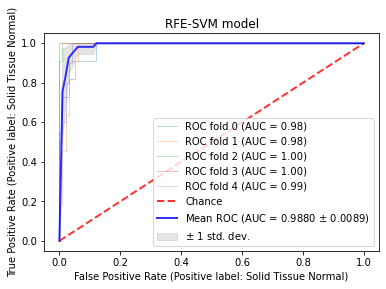

In [18]:
#############################################################################
# Classification and ROC analysis



# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

estimator = LinearSVC(random_state=42)
classifier = RFE(estimator, n_features_to_select= 76, step=0.5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    X[train] = sc.fit_transform(X[train])
    X[test] = sc.transform(X[test])
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="RFE-SVM model",
)
ax.legend(loc="lower right")
plt.show()

No Skill: ROC AUC=0.500
Model: ROC AUC=0.989


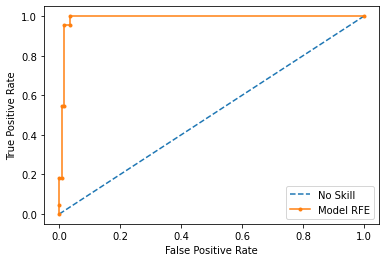

In [19]:
#ROC AUC calculations for the 76 features of RFE Model

#changing the class to discrete numbers for ROC AUC calculation
ss = 0
pp = 0
y_test_binary = y_test.copy()
y_train_binary = y_train.copy()

for i in range(0, y_test_binary.size):
    if (y_test_binary[i] == "Primary Tumor"):
        y_test_binary[i] = int(0)
        pp = pp + 1
    if (y_test_binary[i] == "Solid Tissue Normal"):
        y_test_binary[i] = int(1)
        ss = ss + 1
y_test_binary=y_test_binary.astype('int')

for i in range(0, y_train_binary.size):
    if (y_train_binary[i] == "Primary Tumor"):
        y_train_binary[i] = int(0)
        pp = pp + 1
    if (y_train_binary[i] == "Solid Tissue Normal"):
        y_train_binary[i] = int(1)
        ss = ss + 1
y_train_binary=y_train_binary.astype('int')


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test_binary))]


Y_train_binary = y_train_binary[:]
Y_test_binary = y_test_binary[:]

# predict probabilities
svm = LinearSVC(random_state=42)
model3 = RFE(svm, n_features_to_select= 76, step=0.5)
model3 = model3.fit(X_train, y_train)
lr_probs = model3.decision_function(X_test)

# calculate scores
ns_auc = roc_auc_score(Y_test_binary, ns_probs)
lr_auc = roc_auc_score(Y_test_binary, lr_probs)
# summarize scores: prints the ROC AUC for the model and the no skill classifier that only predicts 0 for all samples
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test_binary, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test_binary, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Model RFE')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


In [20]:
#Create a list with indices of RFE Features
RFE_features = np.where(selector.support_ == 1)
RFE_features = np.asarray(RFE_features)
rfe_f = []
for i in RFE_features:
  for s in i:
    rfe_f.append(s)
rfe_f = np.asarray(rfe_f)

In [21]:
#Create list with common features among techniques
similar_all = []
similar_rfe_RF = []
similar_rfe_MI = []

count = 0
for f in it:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_MI.append(f)
print("number of similar features between RFE and MI: ", count)

count = 0
for f in important_f:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_rfe_RF.append(f)
print("number of similar features between RFE and RF: ", count)

count = 0
for f in similarity:
  for t in rfe_f:
    if (f == t):
      count = count + 1
      similar_all.append(f)
print("number of similar features between RF and MI: ", len(similarity))
print("number of similar features between RFE, RF and MI: ", count)


number of similar features between RFE and MI:  12
number of similar features between RFE and RF:  50
number of similar features between RF and MI:  18
number of similar features between RFE, RF and MI:  12


In [22]:
#A LinearSVC Model using the similar features between all of them
startTime = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = X_train[:, similar_all]
X_test = X_test[:, similar_all]
Y_train = y_train[:]
Y_test = y_test[:]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train[:]
Y_test = Y_test[:]
clf = LinearSVC(random_state=42)

clf.fit(X_train, Y_train)

endTime = time.time()
print('Score: ' + str(clf.score(X_test, Y_test)))
print('Time: ' + str(endTime - startTime))
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average = 'weighted'))


Score: 0.9772727272727273
Time: 3.9629509449005127
[[197   1]
 [  4  18]]
                     precision    recall  f1-score   support

      Primary Tumor       0.98      0.99      0.99       198
Solid Tissue Normal       0.95      0.82      0.88        22

           accuracy                           0.98       220
          macro avg       0.96      0.91      0.93       220
       weighted avg       0.98      0.98      0.98       220

0.9772727272727273
(0.976826394344069, 0.9772727272727273, 0.9765266825600586, None)


In [23]:
res = []
for l in ['Primary Tumor', 'Solid Tissue Normal']:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_test)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])

#weighted specificity
specificity = ((res[0][1]*198)+(res[1][1]*22))/220
print('Specificity: ', specificity)

#weighted sensitivity (recall)
sensitivity = ((res[0][2]*198)+(res[1][2]*22))/220
print("Sensitivity: ", sensitivity)

Specificity:  0.8358585858585859
Sensitivity:  0.9772727272727273


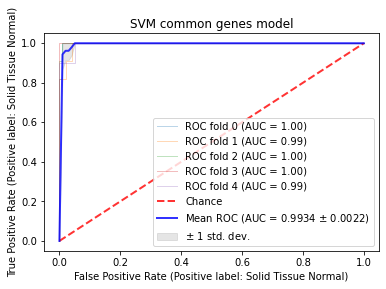

In [24]:
#############################################################################
# Classification and ROC analysis



# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
classifier = LinearSVC(random_state=42)



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    X_train = sc.fit_transform(X[train])
    X_train = X_train[:, similar_all]
    X_test = sc.transform(X[test])
    X_test = X_test[:, similar_all]
    
    classifier.fit(X_train, y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.4f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="SVM common genes model",
)
ax.legend(loc="lower right")
plt.show()